<a href="https://colab.research.google.com/github/panchrissantfdz/Analisis-de-Imagenes-CIC-IPN/blob/main/Arquitectura_Pytorch_Christian_Version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --upgrade torch torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configuración inicial
img_width, img_height = 200, 100
train_data_dir = '/content/drive/MyDrive/Colab Notebooks/Imágenes Ordenadas/Mas40/Entrenamiento'
validation_data_dir = '/content/drive/MyDrive/Colab Notebooks/Imágenes Ordenadas/Mas40/Validación'
nb_train_samples = 255
nb_validation_samples = 51
epochs = 100           #30
batch_size = 8

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomRotation(degrees=(0, 30)),# Rotación aleatoria entre 0 y 30 grados
    transforms.RandomEqualize(), # Ajuste de brillo aleatorio (Equalize)
    transforms.RandomAdjustSharpness(sharpness_factor=2),# Ajuste de nitidez aleatorio con un factor de 2
    transforms.RandomHorizontalFlip(),# Volteo horizontal aleatorio con una probabilidad del 50%
    transforms.RandomVerticalFlip(),# Volteo vertical aleatorio con una probabilidad del 50%


    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [ ]:
validation_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Datasets y DataLoaders
train_dataset = datasets.ImageFolder(train_data_dir, transform=train_transforms)
validation_dataset = datasets.ImageFolder(validation_data_dir, transform=validation_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False) #Quitar
test_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Definición del modelo
class CICModel(nn.Module):
    def __init__(self):
        super(CICModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3),  # Primera capa convolucional
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Primera capa de max-pooling
            nn.Dropout(0.25),

            nn.Conv2d(64, 64, kernel_size=3),  # Segunda capa convolucional
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Segunda capa de max-pooling
            nn.Dropout(0.25),

            nn.Conv2d(64, 64, kernel_size=3),  # Tercera capa convolucional
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Tercera capa de max-pooling
            nn.Dropout(0.25),

            nn.Conv2d(64, 64, kernel_size=3),  # Cuarta capa convolucional
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Cuarta capa de max-pooling
            nn.Dropout(0.25)

        )

        # Calcular el tamaño dinámico de la salida de la capa convolucional
        dummy_input = torch.zeros(1, 3, img_height, img_width)  # Entrada ficticia
        with torch.no_grad():
            output_size = self.features(dummy_input).view(-1).shape[0]  # Calcular tamaño de salida
        print(f"Tamaño de salida después de las capas convolucionales: {output_size}")

        self.classifier = nn.Sequential(
            nn.Flatten(),  # Aplanar la salida para la capa lineal
            nn.Linear(output_size, 256),  # Primera capa lineal
            nn.ReLU(),
            nn.Linear(256, 256),  # Segunda capa lineal
            nn.ReLU(),
            nn.Linear(256, 3),  # Capa de salida con 3 clases
            nn.Softmax(dim=1)  # Activación softmax para clasificación
        )

    def forward(self, x):
        x = self.features(x)  # Pasar por las capas convolucionales
        x = self.classifier(x)  # Pasar por las capas lineales
        return x


In [ ]:
#Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)


In [ ]:
#//////////////////////////////////////
#
#     ENTRENAMIENTO DE LA RED NEURONAL
#
#/////////////////////////////////////

model = CICModel().to(device)

# Compilación del modelo
criterion = nn.CrossEntropyLoss()  # Función de pérdida para clasificación
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Optimizador Adam

# (Opcional) Early Stopping, si deseas usarlo basado en métricas de entrenamiento
early_stopping = EarlyStopping(patience=100, delta=0.001)

tiempo_inicial = time.time()
train_accuracies = []
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Limpiar los gradientes
        outputs = model(inputs)  # Pasar datos por el modelo
        loss = criterion(outputs, labels)  # Calcular la pérdida
        loss.backward()  # Retropropagación
        optimizer.step()  # Actualizar los pesos

        running_loss += loss.item() * inputs.size(0)  # Acumular la pérdida total
        _, predicted = torch.max(outputs, 1)  # Predecir etiquetas
        total += labels.size(0)  # Total de muestras procesadas
        correct += (predicted == labels).sum().item()  # Contar predicciones correctas

    train_acc = correct / total  # Exactitud de entrenamiento
    train_loss = running_loss / total
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Train Accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}")

    # Si deseas usar early stopping basado en alguna métrica del entrenamiento, puedes llamarlo aquí
    early_stopping(train_acc, model)
    if early_stopping.early_stop:
        print("Early stopping activado. Finalizando entrenamiento.")
        break

# (Opcional) Cargar el mejor modelo si early stopping se utilizó
if early_stopping.best_model_state is not None:
    early_stopping.load_best_model(model)

# Tiempo de ejecución del entrenamiento
tiempo_final = time.time()
tiempo_ejecucion = tiempo_final - tiempo_inicial
print(f"Tiempo de ejecución del entrenamiento: {tiempo_ejecucion:.2f} segundos")

#/////////////////////////////////////////////
#
#     VALIDACIÓN CON LOS PESOS ENTRENADOS
#
#/////////////////////////////////////////////
'''
model.eval()
val_accuracies, val_losses = [], []
val_correct, val_total, val_running_loss = 0, 0, 0.0
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()
        val_running_loss += loss.item() * inputs.size(0)

val_acc = val_correct / val_total
val_loss = val_running_loss / val_total
val_accuracies.append(val_acc)
val_losses.append(val_loss)

print(f"Final Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

'''



model.eval()
test_accuracies, test_losses = [], []
test_correct, test_total, test_running_loss = 0, 0, 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_running_loss += loss.item() * inputs.size(0)

test_acc = test_correct / test_total
test_loss = test_running_loss / test_total
test_accuracies.append(test_acc)
test_losses.append(test_loss)

print(f"Final Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

Tamaño de salida después de las capas convolucionales: 2560
Epoch [1/100], Train Accuracy: 0.5141, Loss: 1.0732
Epoch [2/100], Train Accuracy: 0.5537, Loss: 0.9806
Epoch [3/100], Train Accuracy: 0.5537, Loss: 0.9621
Epoch [4/100], Train Accuracy: 0.5537, Loss: 0.9451
Epoch [5/100], Train Accuracy: 0.5650, Loss: 0.9311
Epoch [6/100], Train Accuracy: 0.6384, Loss: 0.9072
Epoch [7/100], Train Accuracy: 0.7627, Loss: 0.8228
Epoch [8/100], Train Accuracy: 0.9040, Loss: 0.6986
Epoch [9/100], Train Accuracy: 0.8814, Loss: 0.6666
Epoch [10/100], Train Accuracy: 0.8870, Loss: 0.6775
Epoch [11/100], Train Accuracy: 0.9322, Loss: 0.6232
Epoch [12/100], Train Accuracy: 0.9605, Loss: 0.5974
Epoch [13/100], Train Accuracy: 0.7740, Loss: 0.7786
Epoch [14/100], Train Accuracy: 0.9379, Loss: 0.6109
Epoch [15/100], Train Accuracy: 0.9492, Loss: 0.5966
Epoch [16/100], Train Accuracy: 0.9605, Loss: 0.5904
Epoch [17/100], Train Accuracy: 0.9718, Loss: 0.5839
Epoch [18/100], Train Accuracy: 0.9774, Loss: 0.

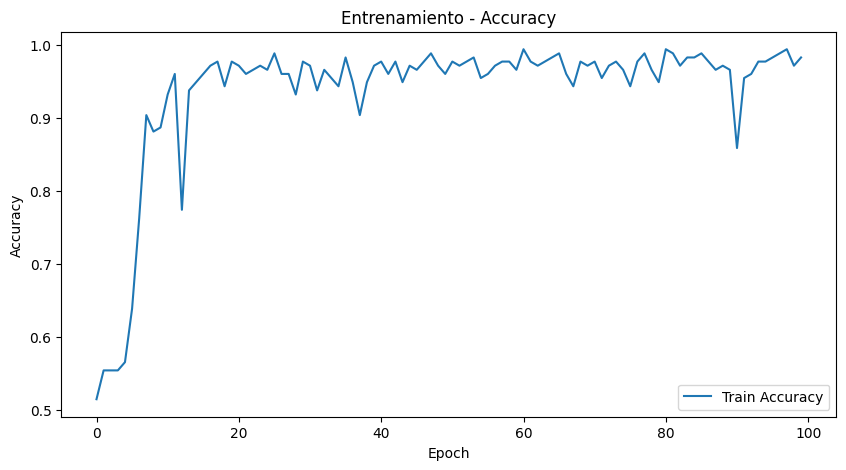

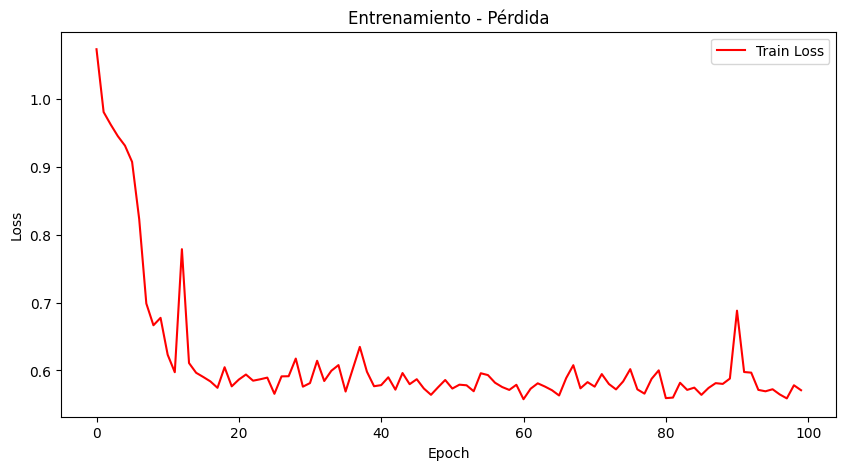

"\nplt.figure(figsize=(10,5))\nplt.plot(val_accuracies, label='Validation Accuracy')\nplt.title('Validación - Accuracy')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy')\nplt.legend()\nplt.show()\n\nplt.figure(figsize=(10,5))\nplt.plot(val_losses, label='Validation Loss', color='red')\nplt.title('Validación - Pérdida')\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\nplt.legend()\nplt.show()\n\n"

In [ ]:
# Curvas de aprendizaje
#plt.plot(train_accuracies, label='Train Accuracy')
#plt.plot(val_accuracies, label='Validation Accuracy')
#plt.title('Model Accuracy')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
#plt.legend()
#plt.show()

# Graficar curvas de aprendizaje
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Entrenamiento - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss', color='red')
plt.title('Entrenamiento - Pérdida')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

'''
plt.figure(figsize=(10,5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validación - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Validación - Pérdida')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

'''


In [ ]:
#/////////////////////////////////////////////
#
# Guardar el modelo
#
#////////////////////////////////////////////

model_path = '/content/drive/MyDrive/Colab Notebooks/VGG16_prueba5.pth'
torch.save(model.state_dict(), model_path)  # Guardar los pesos del modelo
print(f"Modelo guardado en {model_path}")


Modelo guardado en /content/drive/MyDrive/Colab Notebooks/VGG16_prueba5.pth


In [ ]:
print("Clases detectadas por ImageFolder:", train_dataset.classes)
print("Clases detectadas por ImageFolder:", validation_dataset.classes)

Clases detectadas por ImageFolder: ['DR', 'HR', 'WNL']
Clases detectadas por ImageFolder: ['DR', 'HR', 'WNL']


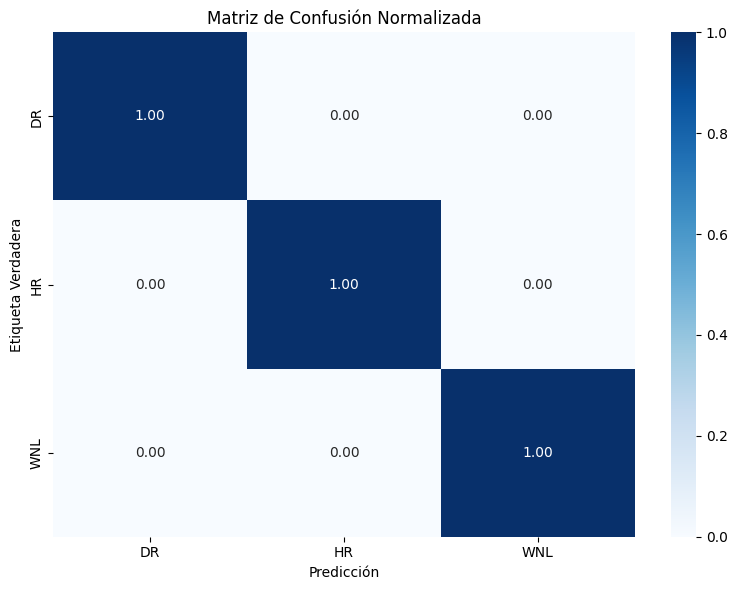

Final Validation Accuracy: 1.0000


In [ ]:
#////////////////////////////////////////////////////////
#
#     MATRIZ DE CONFUSIÓN
#
#///////////////////////////////////////////////////////


from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

# Generar matriz de confusión
model.eval()
y_pred, y_true = [], []

with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Clases
classes = ['DR', 'HR', 'WNL']

# Construir matriz de confusión
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=classes, columns=classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sn.heatmap(df_cm, annot=True, fmt=".2f", cmap="Blues")
plt.title("Matriz de Confusión Normalizada")
plt.ylabel("Etiqueta Verdadera")
plt.xlabel("Predicción")
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Imprimir exactitud final
final_accuracy = np.trace(cf_matrix) / np.sum(cf_matrix)
print(f"Final Validation Accuracy: {final_accuracy:.4f}")